# <div align="center"><font color='white'>  </font></div>
# <div align="center"><font color='white'> EmotiScan  </font></div>
## <div align="center"> <font color='white'> Emotion and FACS Code Prediction using DenseNet201 model</font></div>
---

# **Aim**
The aim of the project is to develop an end-to-end trained deep Convolutional Neural Network (CNN) and leverage deep learning techniques to build a model that can automatically detect and classify Facial Emotions and Facial Action Coding System (FACS) codes present in images.

1.   **High-Level Emotion:**

    The first objective of the task is to determine whether the image displays a "Positive," "Negative," or "Surprised" emotion on the subject's face. This involves training the CNN to recognize and classify different emotional states based on facial expressions.


2.   **FACS Codes:**

    The second objective aims to predict whether a particular facial action corresponds to a specific FACS code or not. The FACS codes represent different facial movements and muscle actions.

---
Note: You can navigate through different sections through the Table of Contents Tab.

# **Data**

The dataset being used for this project is a **subset** obtained from CK+ dataset published with Lucey, Patrick, Jeffrey F.Cohn, Takeo Kanade, Jason Saragih, Zara Ambadar, and Iain Matthews.

Before building a model it is essential we have a look at the data set it self and investigate its variables.

In [1]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Copy the data zip file from Google Drive
!cp /content/drive/MyDrive/EmotiScan/data-1.zip .
!unzip -q -o data-1.zip
!rm data-1.zip

Mounted at /content/drive


In [26]:
# Import Libraries for Data Manipulation and Visualization
import pandas as pd
import numpy as np
import seaborn as sns
import random
import cv2
import matplotlib.pyplot as plt

# Import Libraries for Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Uncomment to install TensorFlow Addons
# !pip install tensorflow-addons

# Import TensorFlow and Keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

# Import Keras Layers and Models
from keras import layers, Model
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Lambda, Dropout
from keras.utils import to_categorical
from keras.applications import DenseNet201

# Import Keras Optimizers, Metrics, and Callbacks
from keras.optimizers import Adam
from keras.metrics import AUC
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# Read the data and the image file paths
data = pd.read_csv("data_labels.csv")
image_paths = data['filepath'].tolist()

data.head()

,subject,sequence,image_index,filepath,file_prefix,AU17,AU1,AU2,AU25,AU27,...,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26,high_level_emotion
0,S005,1,11,./cohn-kanade-images/S005/001/S005_001_0000001...,S005_001_00000011,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
1,S010,1,14,./cohn-kanade-images/S010/001/S010_001_0000001...,S010_001_00000014,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,negative
2,S010,2,14,./cohn-kanade-images/S010/002/S010_002_0000001...,S010_002_00000014,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,surprise
3,S010,3,18,./cohn-kanade-images/S010/003/S010_003_0000001...,S010_003_00000018,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
4,S010,4,19,./cohn-kanade-images/S010/004/S010_004_0000001...,S010_004_00000019,1,0,0,0,0,...,1,1,1,0,0,0,0,0,0,negative


In [4]:
# Structure of the data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   subject             560 non-null    object
 1   sequence            560 non-null    int64 
 2   image_index         560 non-null    int64 
 3   filepath            560 non-null    object
 4   file_prefix         560 non-null    object
 5   AU17                560 non-null    int64 
 6   AU1                 560 non-null    int64 
 7   AU2                 560 non-null    int64 
 8   AU25                560 non-null    int64 
 9   AU27                560 non-null    int64 
 10  AU4                 560 non-null    int64 
 11  AU7                 560 non-null    int64 
 12  AU23                560 non-null    int64 
 13  AU24                560 non-null    int64 
 14  AU6                 560 non-null    int64 
 15  AU12                560 non-null    int64 
 16  AU15                560 no

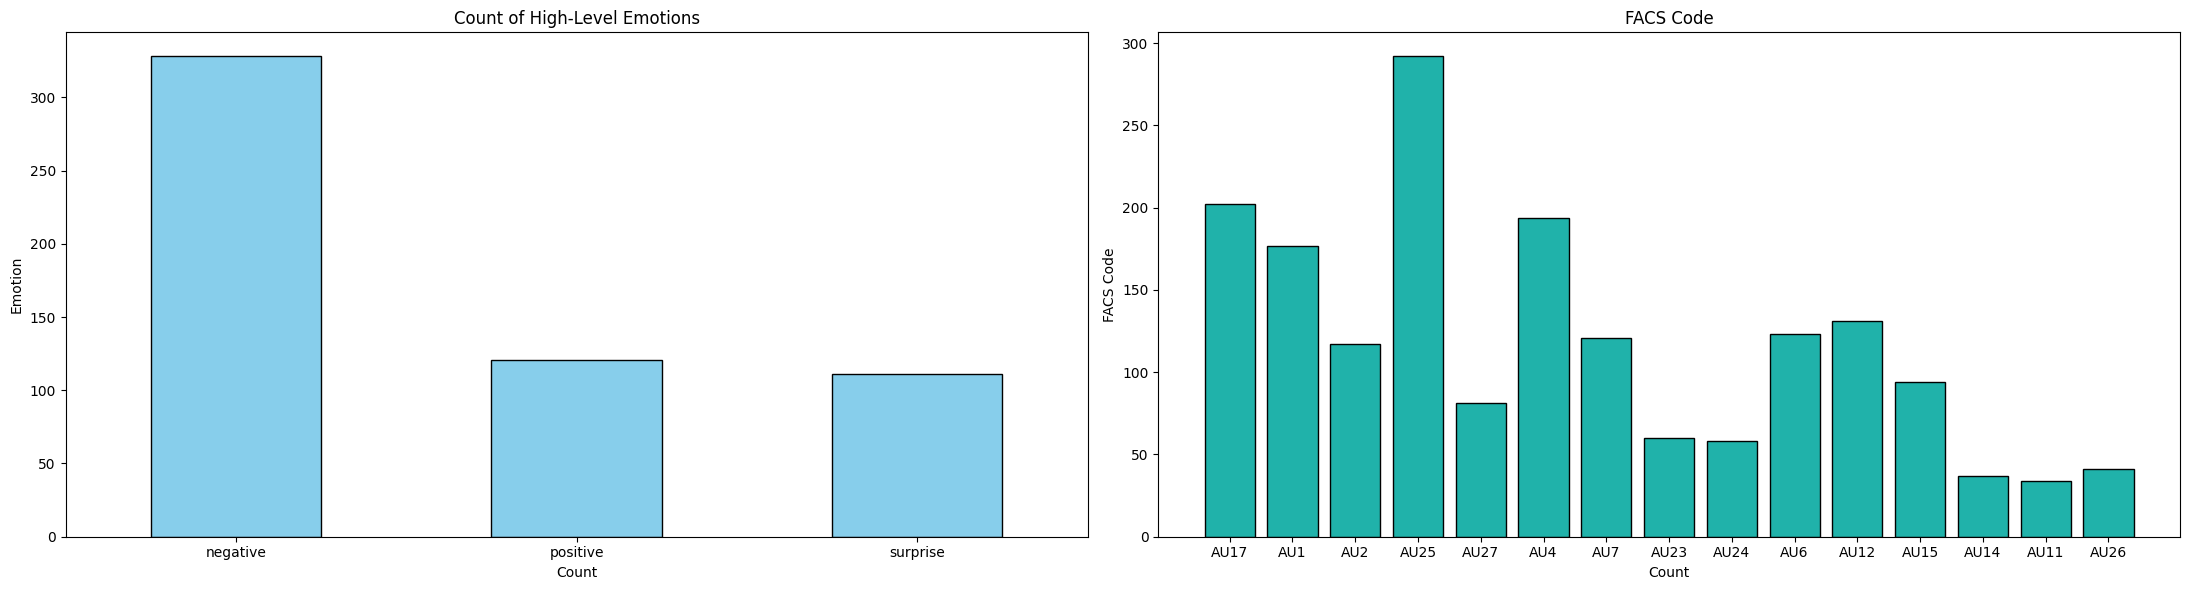

In [5]:
# Visualise the FACS code and Emotion labels
fig, axes = plt.subplots(1, 2, figsize=(22, 6))

# First subplot: High-Level Emotions
data["high_level_emotion"].value_counts().plot(kind="bar", edgecolor="k", ax=axes[0], color='skyblue')
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Emotion")
axes[0].set_title("Count of High-Level Emotions")
axes[0].tick_params(axis="x", rotation=0)

# Second subplot: FACS Codes
facs_columns = data.columns[5:20]
counts = data[facs_columns].sum()

axes[1].bar(counts.index, counts.values, color='lightseagreen', edgecolor="k")
axes[1].set_xlabel('Count')
axes[1].set_ylabel('FACS Code')
axes[1].set_title('FACS Code')
axes[1].tick_params(axis="x")

# Adjust the layout to prevent overlapping labels
plt.tight_layout()
plt.show()

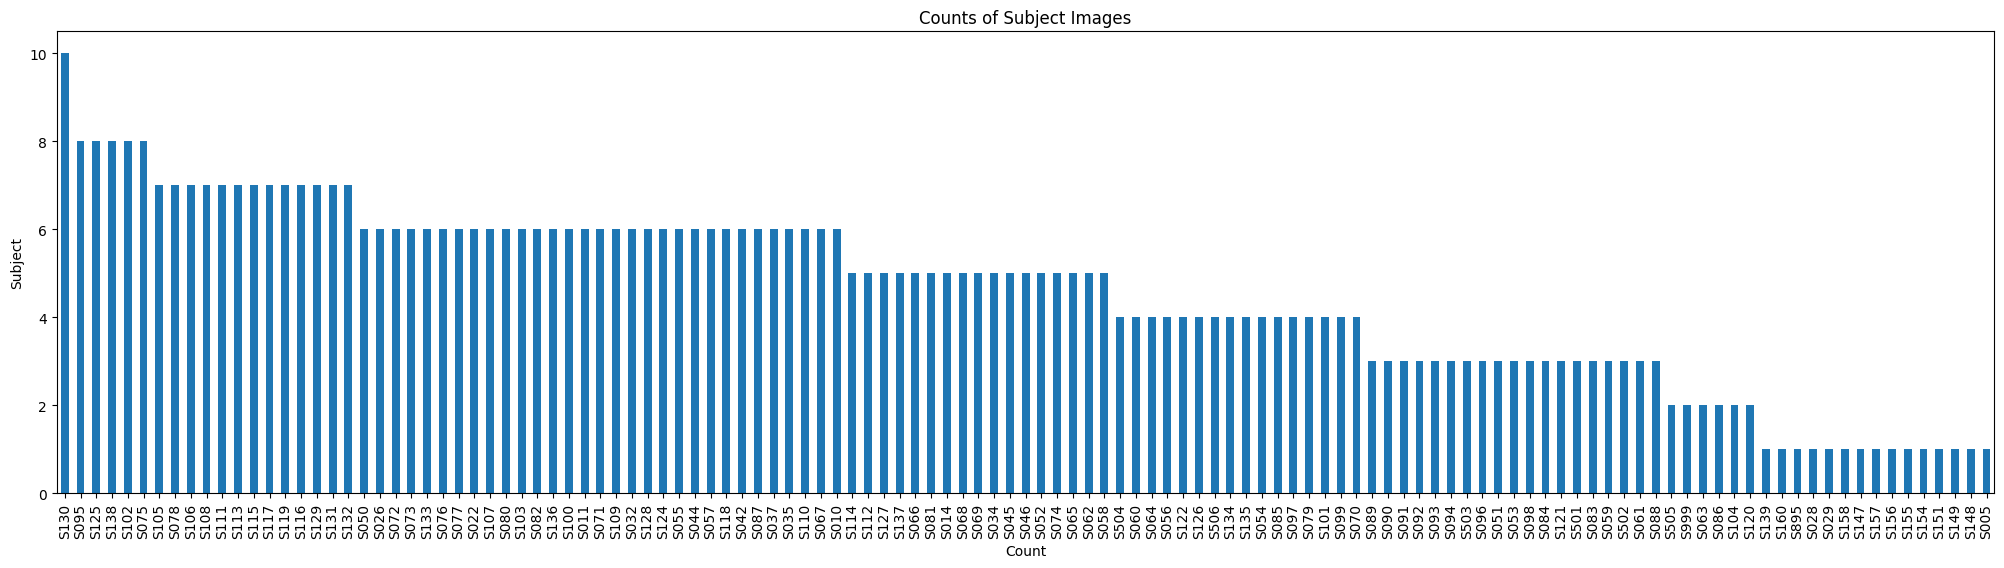

In [6]:
# Plotting the distribution of images per subject
plt.figure(figsize=(25, 6))

data["subject"].value_counts().plot(kind="bar")

plt.xlabel("Count")
plt.ylabel("Subject")
plt.title("Counts of Subject Images")
plt.show()

# **Preprocessing Dataset**

This code segment is essential for preparing the dataset before training machine learning models for emotion recognition and facial action unit classification. It ensures proper mapping of labels and appropriate distribution of data across training, validation, and testing sets to evaluate model performance.

In [7]:
# Create emotion mappings
emotions_to_labels = {'negative': 0, 'positive': 1, 'surprise': 2}

# Apply mappings to the target
emotion_labels = data['high_level_emotion'].map(emotions_to_labels).values
facs_labels = data[['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26']].values

In [8]:
# Get unique subject IDs
unique_subjects = data['subject'].unique()

# Split subjects into training and remaining (validation + test)
subjects_train, subjects_remain = train_test_split(unique_subjects, test_size=0.2, random_state=42)

# Split remaining subjects into validation and test
subjects_val, subjects_test = train_test_split(subjects_remain, test_size=0.45, random_state=42)

# Create splits based on selected subjects
train_set = data[data['subject'].isin(subjects_train)]
val_set = data[data['subject'].isin(subjects_val)]
test_set = data[data['subject'].isin(subjects_test)]

In [32]:
print("Number of observations in the training set: ",len(train_set))
print("Number of observations in the validation set: ",len(val_set))
print("Number of observations in the testing set: ",len(test_set))

Number of observations in the training set:  443
Number of observations in the validation set:  60
Number of observations in the testing set:  57


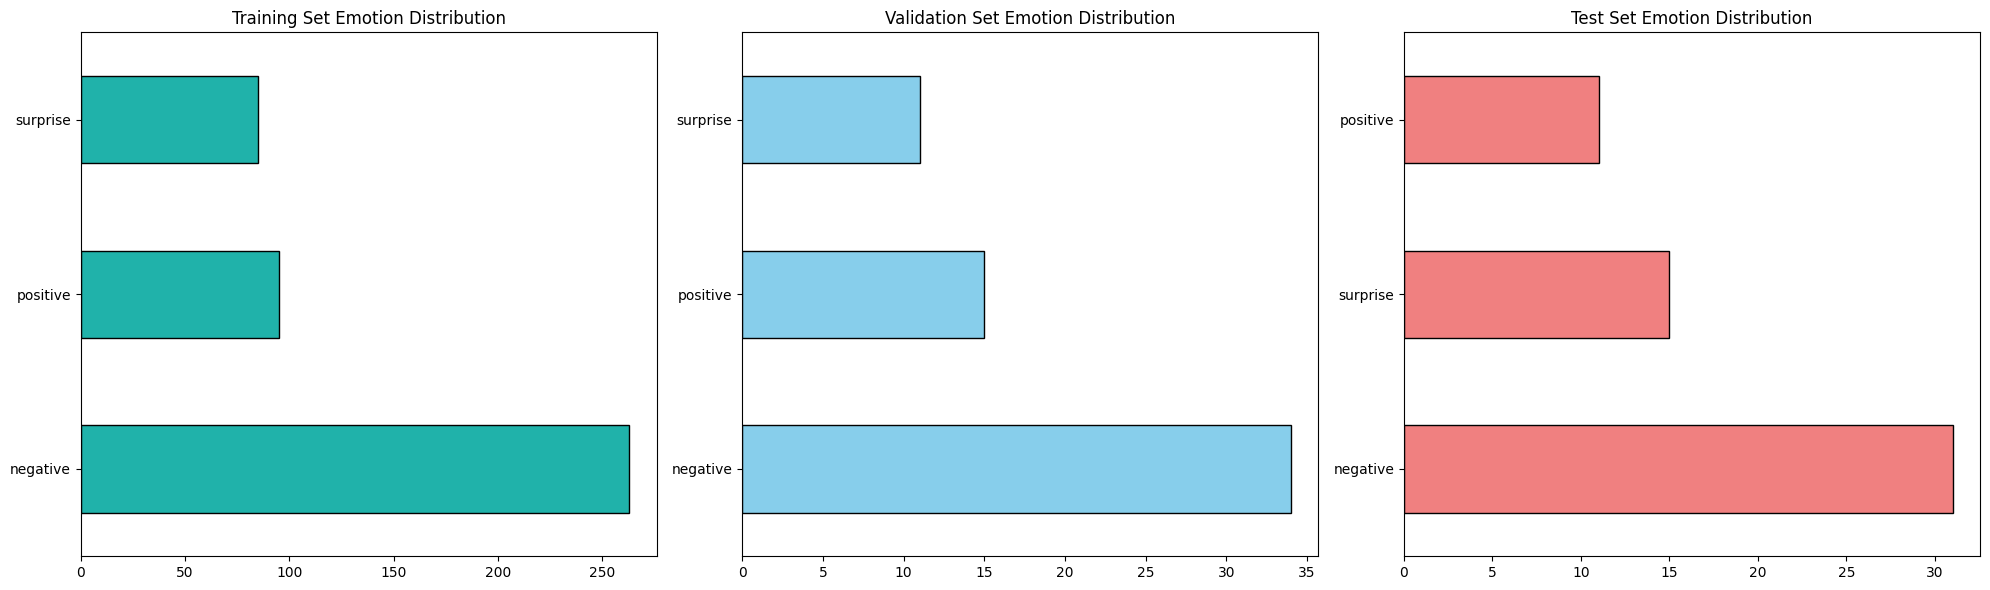

In [10]:
# Plot the distribution of emotion classes in the respective splits
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

train_set['high_level_emotion'].value_counts().plot(kind='barh', ax=axes[0], color='lightseagreen', edgecolor="k")
axes[0].set_title('Training Set Emotion Distribution')
axes[0].tick_params(axis='x', rotation=0)

val_set['high_level_emotion'].value_counts().plot(kind='barh', ax=axes[1], color='skyblue', edgecolor="k")
axes[1].set_title('Validation Set Emotion Distribution')
axes[1].tick_params(axis='x', rotation=0)

test_set['high_level_emotion'].value_counts().plot(kind='barh', ax=axes[2], color='lightcoral', edgecolor="k")
axes[2].set_title('Test Set Emotion Distribution')
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

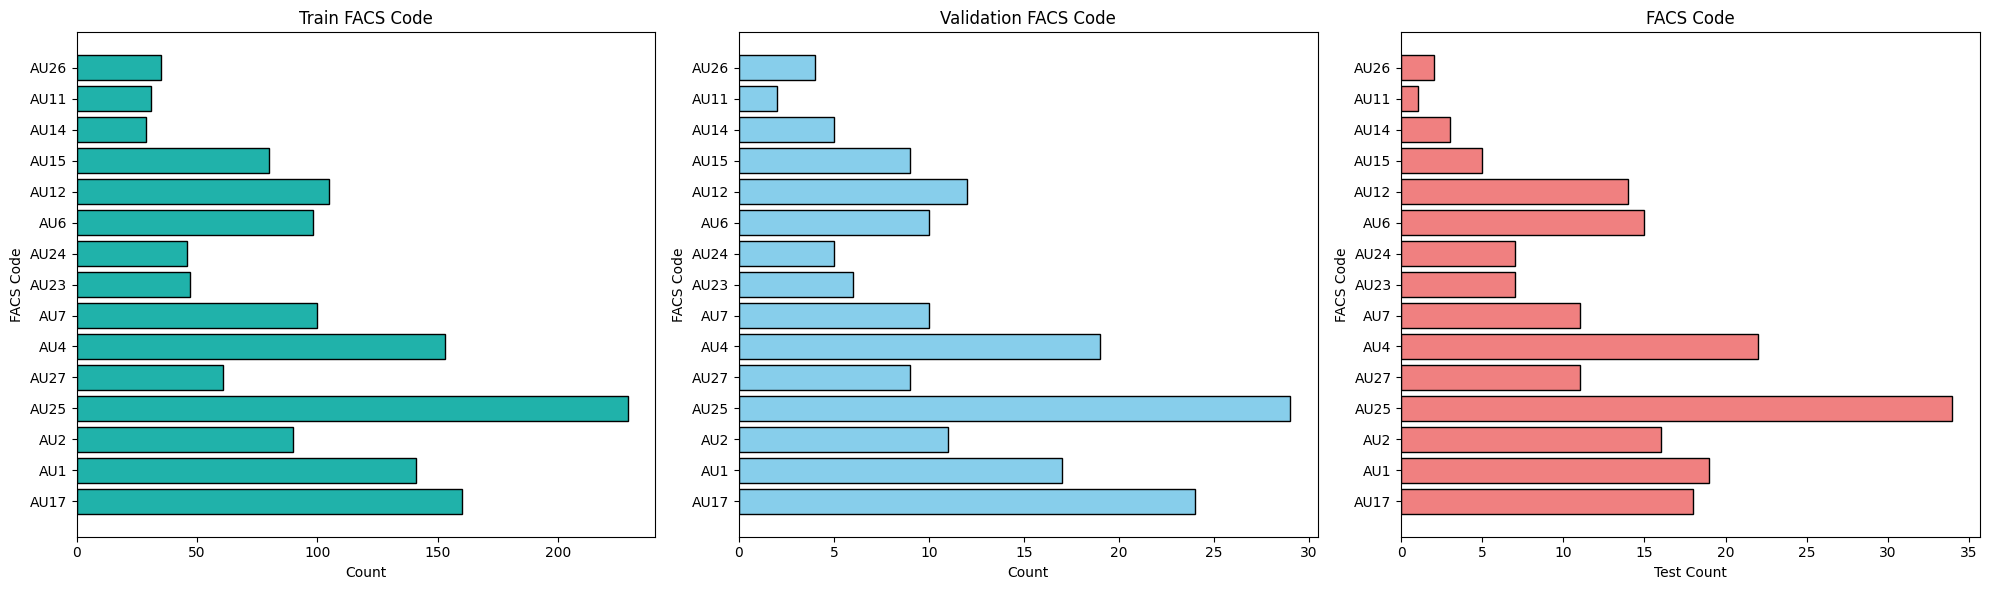

In [11]:
# Plot the distribution of FACS classes in the respective splits
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

train_counts = train_set[train_set.columns[5:20]].sum()
val_counts = val_set[val_set.columns[5:20]].sum()
test_counts = test_set[test_set.columns[5:20]].sum()

axes[0].barh(train_counts.index, train_counts.values, color='lightseagreen', edgecolor="k")
axes[0].set_xlabel('Count')
axes[0].set_ylabel('FACS Code')
axes[0].set_title('Train FACS Code')
axes[0].tick_params(axis="x")

axes[1].barh(val_counts.index, val_counts.values, color='skyblue', edgecolor="k")
axes[1].set_xlabel('Count')
axes[1].set_ylabel('FACS Code')
axes[1].set_title('Validation FACS Code')
axes[1].tick_params(axis="x")

axes[2].barh(test_counts.index, test_counts.values, color='lightcoral', edgecolor="k")
axes[2].set_xlabel('Test Count')
axes[2].set_ylabel('FACS Code')
axes[2].set_title('FACS Code')
axes[2].tick_params(axis="x")

# Adjust the layout to prevent overlapping labels
plt.tight_layout()
plt.show()

# **Data Loader**

DataGenerator is used to efficiently load and preprocess data for training deep learning models. It takes image file paths, corresponding facs_features, emotion_labels, batch size, input size, and optional augmentation as inputs.
The class initializes attributes such as image paths, facs features, emotion labels, batch size, etc.

* The **__len__** method returns the number of batches per epoch based on the available data.
* The **__getitem__** method fetches a batch of data by selecting batch indexes, loading images, and preprocessing them.
The on_epoch_end method shuffles the data indexes at the end of each epoch, if enabled.
* The **load_and_preprocess_image** method loads and preprocesses a single image, applying augmentation if enabled.

The generator improves memory utilization and enables integration with the training loop while ensuring the data is properly preprocessed and augmented to enhance model generalization.

In [12]:
class DataGenerator(keras.utils.Sequence):

  # Initialize the data generator
  def __init__(self, image_paths, facs_features, emotion_labels, batch_size, input_size, shuffle=True, Augment=True):
    # Initialize variables
    self.image_paths = image_paths
    self.facs_features = facs_features
    self.emotion_labels = emotion_labels
    self.dim = (224, 224, 3)
    self.batch_size = batch_size
    self.input_size = input_size
    self.shuffle = shuffle
    self.Augment = Augment
    self.indexes = np.arange(len(self.image_paths))
    self.data_mean = 0
    self.data_std = 255.0

  # Get the number of batches
  def __len__(self):
    return int(np.ceil(len(self.image_paths) / self.batch_size))

  # Get a batch of data
  def __getitem__(self, index):
    # Select batch indexes
    batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    # Load and preprocess images
    batch_image_paths = [self.image_paths[i] for i in batch_indexes]
    batch_images = np.array([self.load_and_preprocess_image(path) for path in batch_image_paths])

    # Get batch facs features and emotion labels
    batch_facs_features = self.facs_features[batch_indexes]
    batch_emotion_labels = self.emotion_labels[batch_indexes]
    batch_emotion_labels_one_hot = to_categorical(batch_emotion_labels, num_classes=3)

    return batch_images, {'facs_output': batch_facs_features, 'emotion_output': batch_emotion_labels_one_hot}

  # Shuffle data at the end of each epoch
  def on_epoch_end(self):
    if self.shuffle:
      np.random.shuffle(self.indexes)

  # Load and preprocess a single image
  def load_and_preprocess_image(self, image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(image, (224, 224))

    # Apply data augmentation if enabled
    if self.Augment:
      image = tf.keras.preprocessing.image.random_rotation(image, 10)
      image = tf.keras.preprocessing.image.random_shift(image, 0.15, 0.15)
      image = tf.keras.preprocessing.image.random_zoom(image, (0.8, 1.2))
      image = tf.image.random_flip_left_right(image)

      image = tf.image.random_brightness(image, max_delta=0.1)

      image = tf.image.resize_with_pad(image, 224, 224)
      image = tf.image.random_crop(image, size=self.dim)

    image = (image - self.data_mean) / self.data_std

    return image

In [13]:
# Define data loader parameters
batch_size = 16
input_size = (224, 224)

train_images = train_set['filepath'].tolist()
train_facs_features = train_set[['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26']].values
train_emotion_labels = train_set['high_level_emotion'].map(emotions_to_labels).values

val_images = val_set['filepath'].tolist()
val_facs_features = val_set[['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26']].values
val_emotion_labels = val_set['high_level_emotion'].map(emotions_to_labels).values

test_images = test_set['filepath'].tolist()
test_facs_features = test_set[['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26']].values
test_emotion_labels = test_set['high_level_emotion'].map(emotions_to_labels).values

In [14]:
# Create custom data loader instances
train_data_loader = DataGenerator(train_images,
                                  train_facs_features,
                                  train_emotion_labels,
                                  batch_size,
                                  input_size,
                                  shuffle=True, Augment=True)

val_data_loader = DataGenerator(val_images,
                                val_facs_features,
                                val_emotion_labels,
                                batch_size,
                                input_size,
                                shuffle=True, Augment=False)

test_data_loader = DataGenerator(test_images,
                                 test_facs_features,
                                 test_emotion_labels,
                                 batch_size,
                                 input_size,
                                 shuffle=False, Augment=False)

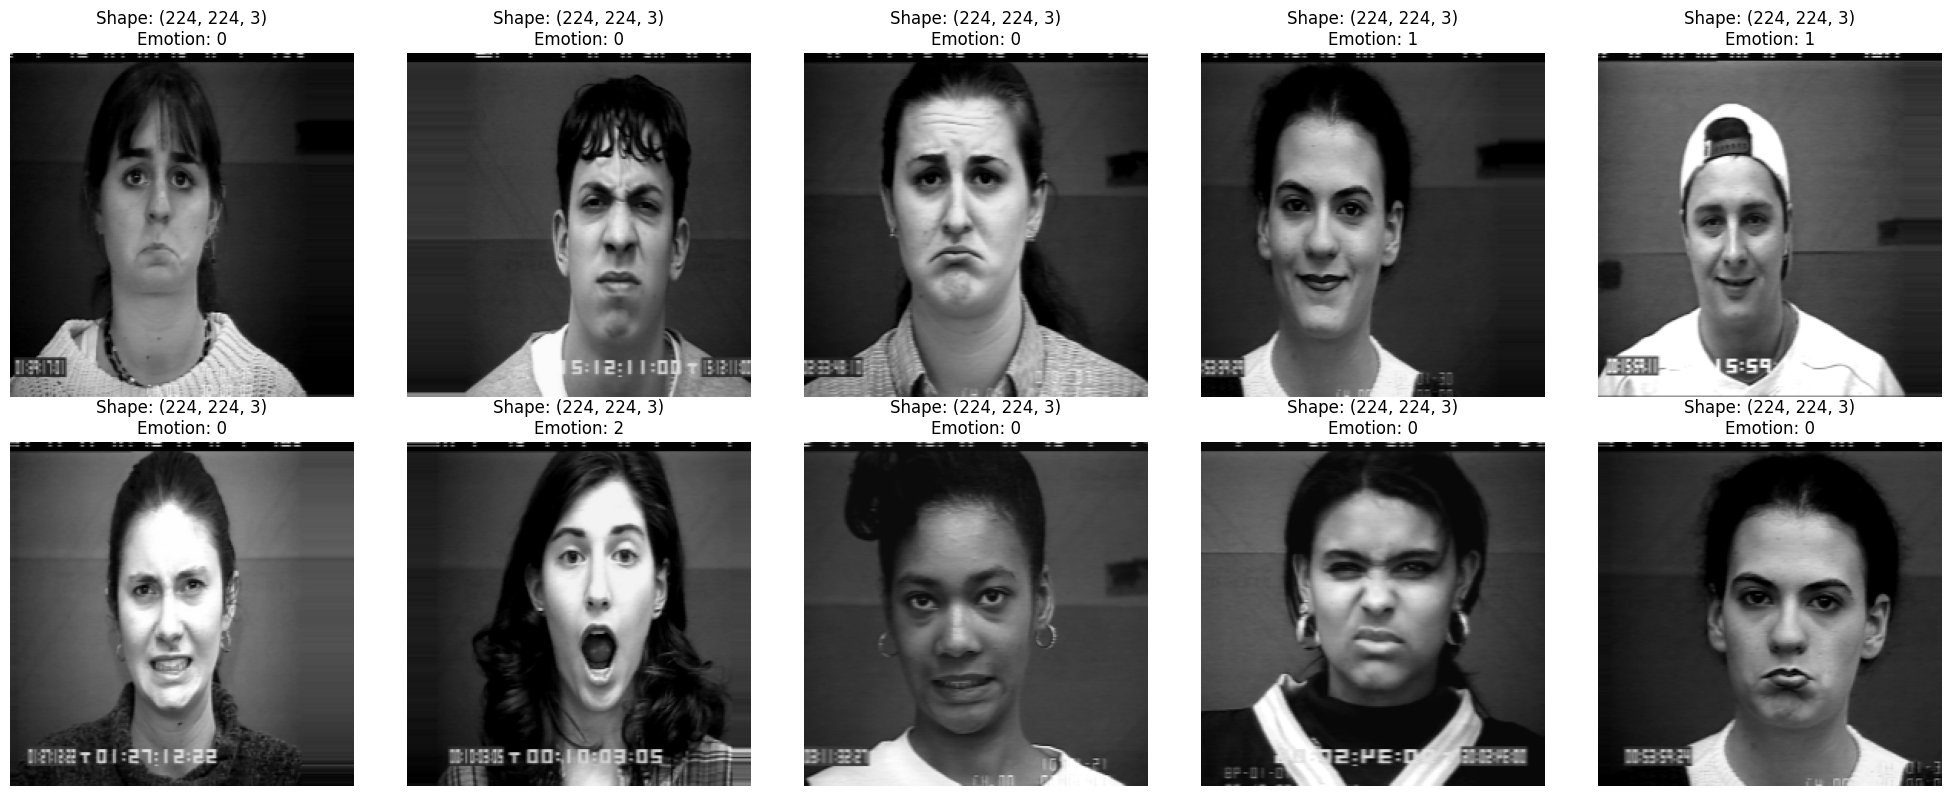

In [15]:
# Select 10 random sample indices to display
num_samples = 10
sample_indices = random.sample(range(len(train_images)), num_samples)

# Load and display sample images
plt.figure(figsize=(20, 8))
for i, idx in enumerate(sample_indices):
    image_path = train_images[idx]
    image = train_data_loader.load_and_preprocess_image(image_path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Shape: {image.shape}\nEmotion: {train_emotion_labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Building the Model**

As we progress to choosing a model that is best suited for this task, it is essential some key choices are made before the implementation this includes but not limited to learning rates, loss function, evaluation meteric, etc. For this task we will be using DenseNet as it has achieved competitive results on various benchmark datasets, including the ImageNet Large Scale Visual Recognition Challenge (ILSVRC).

Also multiple published research papers have used different variants of the VGG architecture as a baseline for facial image recognition.



## **Setting up**

In this task we have FACS code prediction along with Emotion prediction. Since a FAC code can be present or absent (0,1) we will be using the binary crossentropy loss and categorical crossentropy loss for emotion prediction as there are multiple classes (negative, positive, surprised). However, before we use these loss meterics it is important to remember that our data set is highly imbalanced as seen in the [Data Section](https://colab.research.google.com/drive/1f7plu_Pkqo7I9p-8eM2W-HTUD1tc2-Lr#scrollTo=Data) therefore these loss functions will need to be weighted.

The next step would be to choose an appropriate evaluation metric. In the case of emotion prediction it is a multiclass classification problem and given that the classes are imbalanced and no particular preference to either the type 1 or type 2 error, the chosen meteric is "Macro F1-Score".

The rationale behind choosing this metric is that the F1 macro score is commonly used in multi-class classification problems to evaluate the overall performance of the model across all classes. It calculates the F1 score for each class and then computes the average across classes. F1 macro considers precision and recall for each class, making it suitable for multi-class imbalanced datasets. It gives equal weight to all classes, preventing bias towards the majority class.

As for FACS code prediction the chosen metric is AUC PR (Area Under the Precision-Recall Curve). AUC PR is used in binary classification, particularly when dealing with imbalanced datasets. It focuses on the precision-recall trade-off, which is important when positive class samples are rare. AUC PR provides insights into the model's performance in capturing positive samples while maintaining a high precision. It's a better choice when positive class samples are much fewer than negative class samples.

In [16]:
facs_class_weights = {}
facs_codes_list = ['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26']

# Calculate class weights for emotion output
emotion_class_weights = compute_class_weight('balanced', classes=np.unique(train_emotion_labels), y=train_emotion_labels)
emotion_class_weights = dict(enumerate(emotion_class_weights))

print("Emotion Class weights: \n\n", emotion_class_weights)
print("\n")
print("=" * 75)
print("\n")

for facs_code in facs_codes_list:
    # Get class labels and counts for the FACS code
    classes = train_set[facs_code].unique()
    counts = train_set[facs_code].value_counts().sort_index()

    # Compute class weights for the FACS code
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_set[facs_code])
    facs_class_weights[facs_code] = dict(zip(classes, class_weights))

# Display FACS code weights
print("FACS Code Weights:\n")
for facs_code, weights in facs_class_weights.items():
    print(f"FACS Code: {facs_code}")
    print("Class Weights:", weights)
    print()


Emotion Class weights: 

 {0: 0.5614702154626109, 1: 1.5543859649122806, 2: 1.7372549019607844}




FACS Code Weights:

FACS Code: AU17
Class Weights: {0: 0.7826855123674912, 1: 1.384375}

FACS Code: AU1
Class Weights: {1: 1.570921985815603, 0: 0.7334437086092715}

FACS Code: AU2
Class Weights: {1: 2.4611111111111112, 0: 0.6274787535410765}

FACS Code: AU25
Class Weights: {1: 0.9672489082969432, 0: 1.0350467289719627}

FACS Code: AU27
Class Weights: {0: 0.5798429319371727, 1: 3.6311475409836067}

FACS Code: AU4
Class Weights: {0: 0.7637931034482759, 1: 1.4477124183006536}

FACS Code: AU7
Class Weights: {0: 0.6457725947521866, 1: 2.215}

FACS Code: AU23
Class Weights: {0: 0.5593434343434344, 1: 4.712765957446808}

FACS Code: AU24
Class Weights: {0: 0.5579345088161209, 1: 4.815217391304348}

FACS Code: AU6
Class Weights: {0: 0.6420289855072464, 1: 2.260204081632653}

FACS Code: AU12
Class Weights: {0: 0.6553254437869822, 1: 2.1095238095238096}

FACS Code: AU15
Class Weights: {0: 0.610192

In [ ]:
# Creating a baseline model using DenseNet201 as a base
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freezing the layers in the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Ensuring padding is set to 'same' for Conv2D layers
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.padding = 'same'

# Adding custom dense layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(670, activation='relu', kernel_regularizer=keras.regularizers.L2(0.02))(x)
x = Dropout(0.35)(x)
x = Dense(372, activation='relu', kernel_regularizer=keras.regularizers.L2(0.02))(x)
x = Dropout(0.35)(x)

# Output layers for FACS codes and emotions
facs_output = Dense(15, activation='sigmoid', name='facs_output')(x)
emotion_output = Dense(3, activation='softmax', name='emotion_output')(x)

# Creating the final model
baseline_model = Model(inputs=base_model.input, outputs=[facs_output, emotion_output])

#==============================================================================#

# Compiling the model with specified optimizer, loss functions, and metrics
baseline_model.compile(optimizer=Adam(learning_rate=0.003),
                       loss={'facs_output': 'binary_crossentropy',
                             'emotion_output': 'categorical_crossentropy'},
                       loss_weights={'facs_output': facs_class_weights,
                                     'emotion_output': emotion_class_weights},
                       metrics={'facs_output': [AUC(curve='PR', name='auc')],
                                'emotion_output': tfa.metrics.F1Score(num_classes=3, average='macro', name='f1M')})

# Adding early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8)


In [18]:
# Training the baseline model using the provided data loaders
baseline_history = baseline_model.fit(train_data_loader,
                    validation_data=val_data_loader,
                    epochs=70,
                    callbacks=[reduce_lr])

Epoch 1/70
28/28 [==============================] - 87s 2s/step - loss: 14.7789 - facs_output_loss: 0.6254 - emotion_output_loss: 1.7296 - facs_output_auc: 0.2715 - emotion_output_f1M: 0.3846 - val_loss: 7.3865 - val_facs_output_loss: 0.4768 - val_emotion_output_loss: 1.0254 - val_facs_output_auc: 0.3709 - val_emotion_output_f1M: 0.2411 - lr: 0.0030
Epoch 2/70
28/28 [==============================] - 39s 1s/step - loss: 5.5135 - facs_output_loss: 0.4822 - emotion_output_loss: 0.8451 - facs_output_auc: 0.3798 - emotion_output_f1M: 0.5132 - val_loss: 4.1149 - val_facs_output_loss: 0.4275 - val_emotion_output_loss: 0.7138 - val_facs_output_auc: 0.5068 - val_emotion_output_f1M: 0.5845 - lr: 0.0030
Epoch 3/70
28/28 [==============================] - 40s 1s/step - loss: 3.5972 - facs_output_loss: 0.4481 - emotion_output_loss: 0.7162 - facs_output_auc: 0.4794 - emotion_output_f1M: 0.6224 - val_loss: 3.1030 - val_facs_output_loss: 0.3992 - val_emotion_output_loss: 0.6912 - val_facs_output_auc:

In [19]:
def plot_metrics(history, facs_metric, emotion_metric):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Plot training and validation loss for FACS codes
    axes[0, 0].plot(history.history['facs_output_loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_facs_output_loss'], label='Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('FACS Output')
    axes[0, 0].legend()

    # Plot training and validation accuracy for FACS codes
    axes[0, 1].plot(history.history[facs_metric], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_' + facs_metric], label='Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('FACS Output')
    axes[0, 1].legend()

    # Plot training and validation loss for emotion labels
    axes[1, 0].plot(history.history['emotion_output_loss'], label='Training Loss')
    axes[1, 0].plot(history.history['val_emotion_output_loss'], label='Validation Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Emotion Output')
    axes[1, 0].legend()

    # Plot training and validation accuracy for emotion labels
    axes[1, 1].plot(history.history['emotion_output_f1M'], label='Training Accuracy')
    axes[1, 1].plot(history.history['val_emotion_output_f1M'], label='Validation Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_title('Emotion Output')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [20]:
def print_test_accuracy(model, test_data_loader):
    test_results = model.evaluate(test_data_loader, steps=len(test_data_loader))

    facs_accuracy = round(test_results[model.metrics_names.index('facs_output_auc')], 3)
    emotion_accuracy = round(test_results[model.metrics_names.index('emotion_output_f1M')], 3)

    print("===" * 39)
    print("Test Accuracy - FACS Codes:", facs_accuracy)
    print("Test Accuracy - Emotion Labels:", emotion_accuracy)

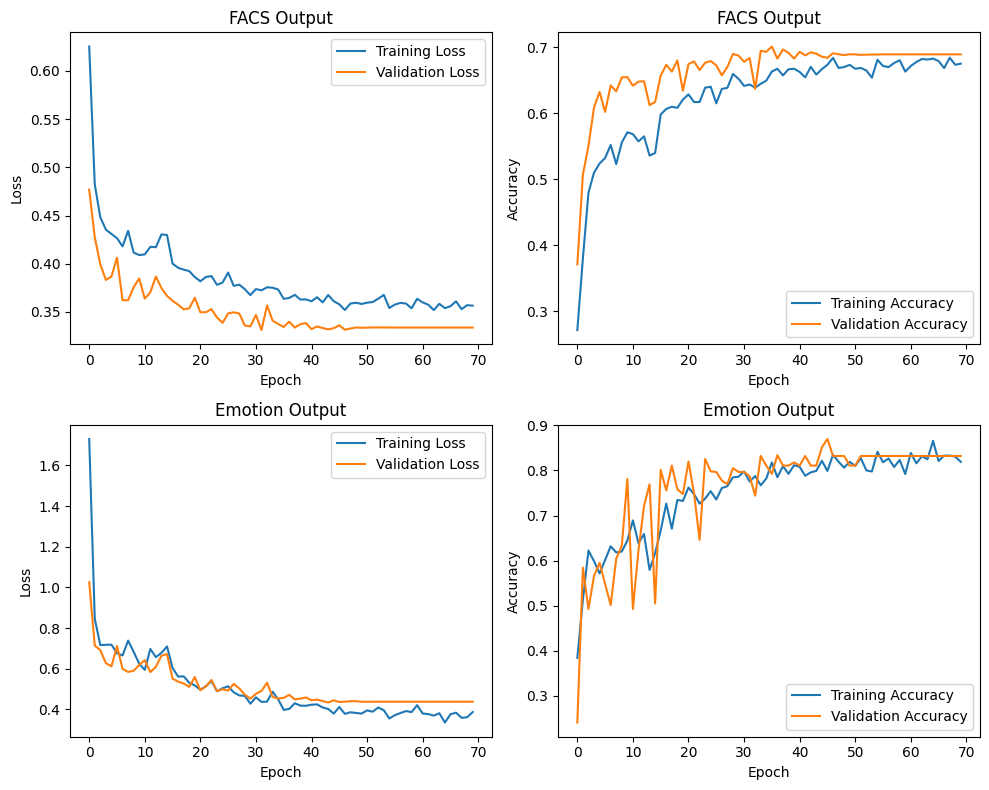

In [21]:
plot_metrics(baseline_history, facs_metric='facs_output_auc', emotion_metric='emotion_output_f1M')

# **Evaluation**

In the evaluation section, the performance of the trained model is assessed using various metrics and visualizations. The primary focus is on understanding how well the model generalizes to unseen data and makes predictions across different classes. This section includes the computation of evaluation metrics such as accuracy, precision, recall, and F1-score for both emotion labels and FACS (Facial Action Coding System) codes.

The classification reports provide a detailed summary of the model's performance, offering insights into precision, recall, and F1-score for each class. For emotion labels, classes such as 'negative,' 'happy,' and 'surprised' are evaluated, while FACS codes like 'AU17,' 'AU1,' and 'AU25' are examined for facial expression analysis.

Furthermore, confusion matrices are visualized to illustrate the model's ability to correctly predict true positives, false positives, and false negatives for both emotion labels and individual FACS codes. These matrices provide a detailed breakdown of the model's performance on a class-by-class basis, aiding in the identification of specific areas where the model excels or may need improvement.

Overall, this evaluation section serves as a comprehensive analysis of the model's effectiveness in recognizing and classifying emotions and facial action units, providing valuable insights for further refinement and application.

In [22]:
test_loss = baseline_model.evaluate(test_data_loader, steps=len(test_data_loader))


print()
print("===" * 50)
print("\nTest Accuracy - FACS Codes:", round(test_loss[baseline_model.metrics_names.index('facs_output_auc')], 3))
print("Test Accuracy - Emotion Labels:", round(test_loss[baseline_model.metrics_names.index('emotion_output_f1M')], 3))

4/4 [==============================] - 5s 2s/step - loss: 1.1269 - facs_output_loss: 0.3296 - emotion_output_loss: 0.4251 - facs_output_auc: 0.7375 - emotion_output_f1M: 0.7789


Test Accuracy - FACS Codes: 0.738
Test Accuracy - Emotion Labels: 0.779


In [23]:
facs_predictions, emotion_predictions = baseline_model.predict(test_data_loader)

4/4 [==============================] - 4s 128ms/step


In [24]:
# Defining Threshold for array of probabilities
threshold = 0.5

facs_predictions = (facs_predictions > threshold).astype(int)
emotion_predictions = (emotion_predictions > threshold).astype(int)

In [27]:
# Emotion class labels
class_labels_emotion = ['negative', 'happy', 'surprised']

# FACS Codes class labels
class_labels_facs = ['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26']

predicted_labels_emotion_classes = np.argmax(emotion_predictions, axis=1)

# True labels and Predicted labels for emotion and FACS codes
true_labels_emotion =  test_emotion_labels
predicted_labels_emotion =  predicted_labels_emotion_classes

true_labels_facs =  test_facs_features
predicted_labels_facs =  facs_predictions

# # Classification Report for Emotion
print("Classification Report - Emotion:")
print(classification_report(true_labels_emotion, predicted_labels_emotion, target_names=class_labels_emotion, zero_division=1))

print('==' * 30)

# Classification Report for FACS Codes
print("\nClassification Report - FACS Codes:")
print(classification_report(true_labels_facs, predicted_labels_facs, zero_division=1, target_names=class_labels_facs))

Classification Report - Emotion:
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84        31
       happy       0.62      0.73      0.67        11
   surprised       1.00      0.87      0.93        15

    accuracy                           0.82        57
   macro avg       0.82      0.81      0.81        57
weighted avg       0.84      0.82      0.83        57


Classification Report - FACS Codes:
              precision    recall  f1-score   support

        AU17       0.82      0.50      0.62        18
         AU1       0.86      0.63      0.73        19
         AU2       0.85      0.69      0.76        16
        AU25       0.79      0.79      0.79        34
        AU27       0.83      0.91      0.87        11
         AU4       0.90      0.41      0.56        22
         AU7       1.00      0.00      0.00        11
        AU23       1.00      0.00      0.00         7
        AU24       1.00      0.00      0.00         7
        

## Inference on FACS Code Classification:

  - Class Imbalances: Notable precision, recall, and F1-score of 1.00 for classes with very low support (AU7, AU23, AU24, AU15, AU14, AU11, AU26) suggest potential class imbalance issues. It is also necessary to note that the data set is small for the task at hand.

  - Strong Predictions: Codes like AU4, AU25, and AU27 demonstrate high precision, recall, and F1-score, indicating effective model performance in identifying instances of these FACS codes.

  - Micro/Macro Averaging: Micro-average F1-score (0.62) is higher than the macro-average (0.37), suggesting relatively better performance on more frequent FACS codes.

  - Weighted Average: The weighted average F1-score (0.56) provides a balanced assessment, indicating moderate overall performance in FACS code prediction.

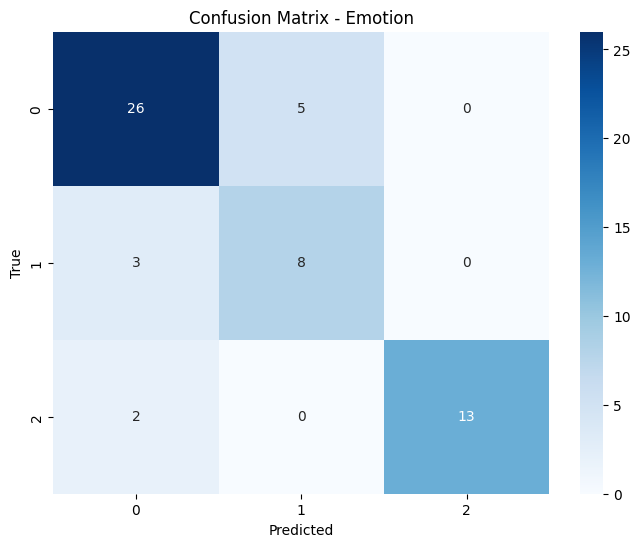

In [28]:
# Confusion Matrix for Emotion
emotion_conf_matrix = confusion_matrix(true_labels_emotion, predicted_labels_emotion)
plt.figure(figsize=(8, 6))
sns.heatmap(emotion_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Emotion')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

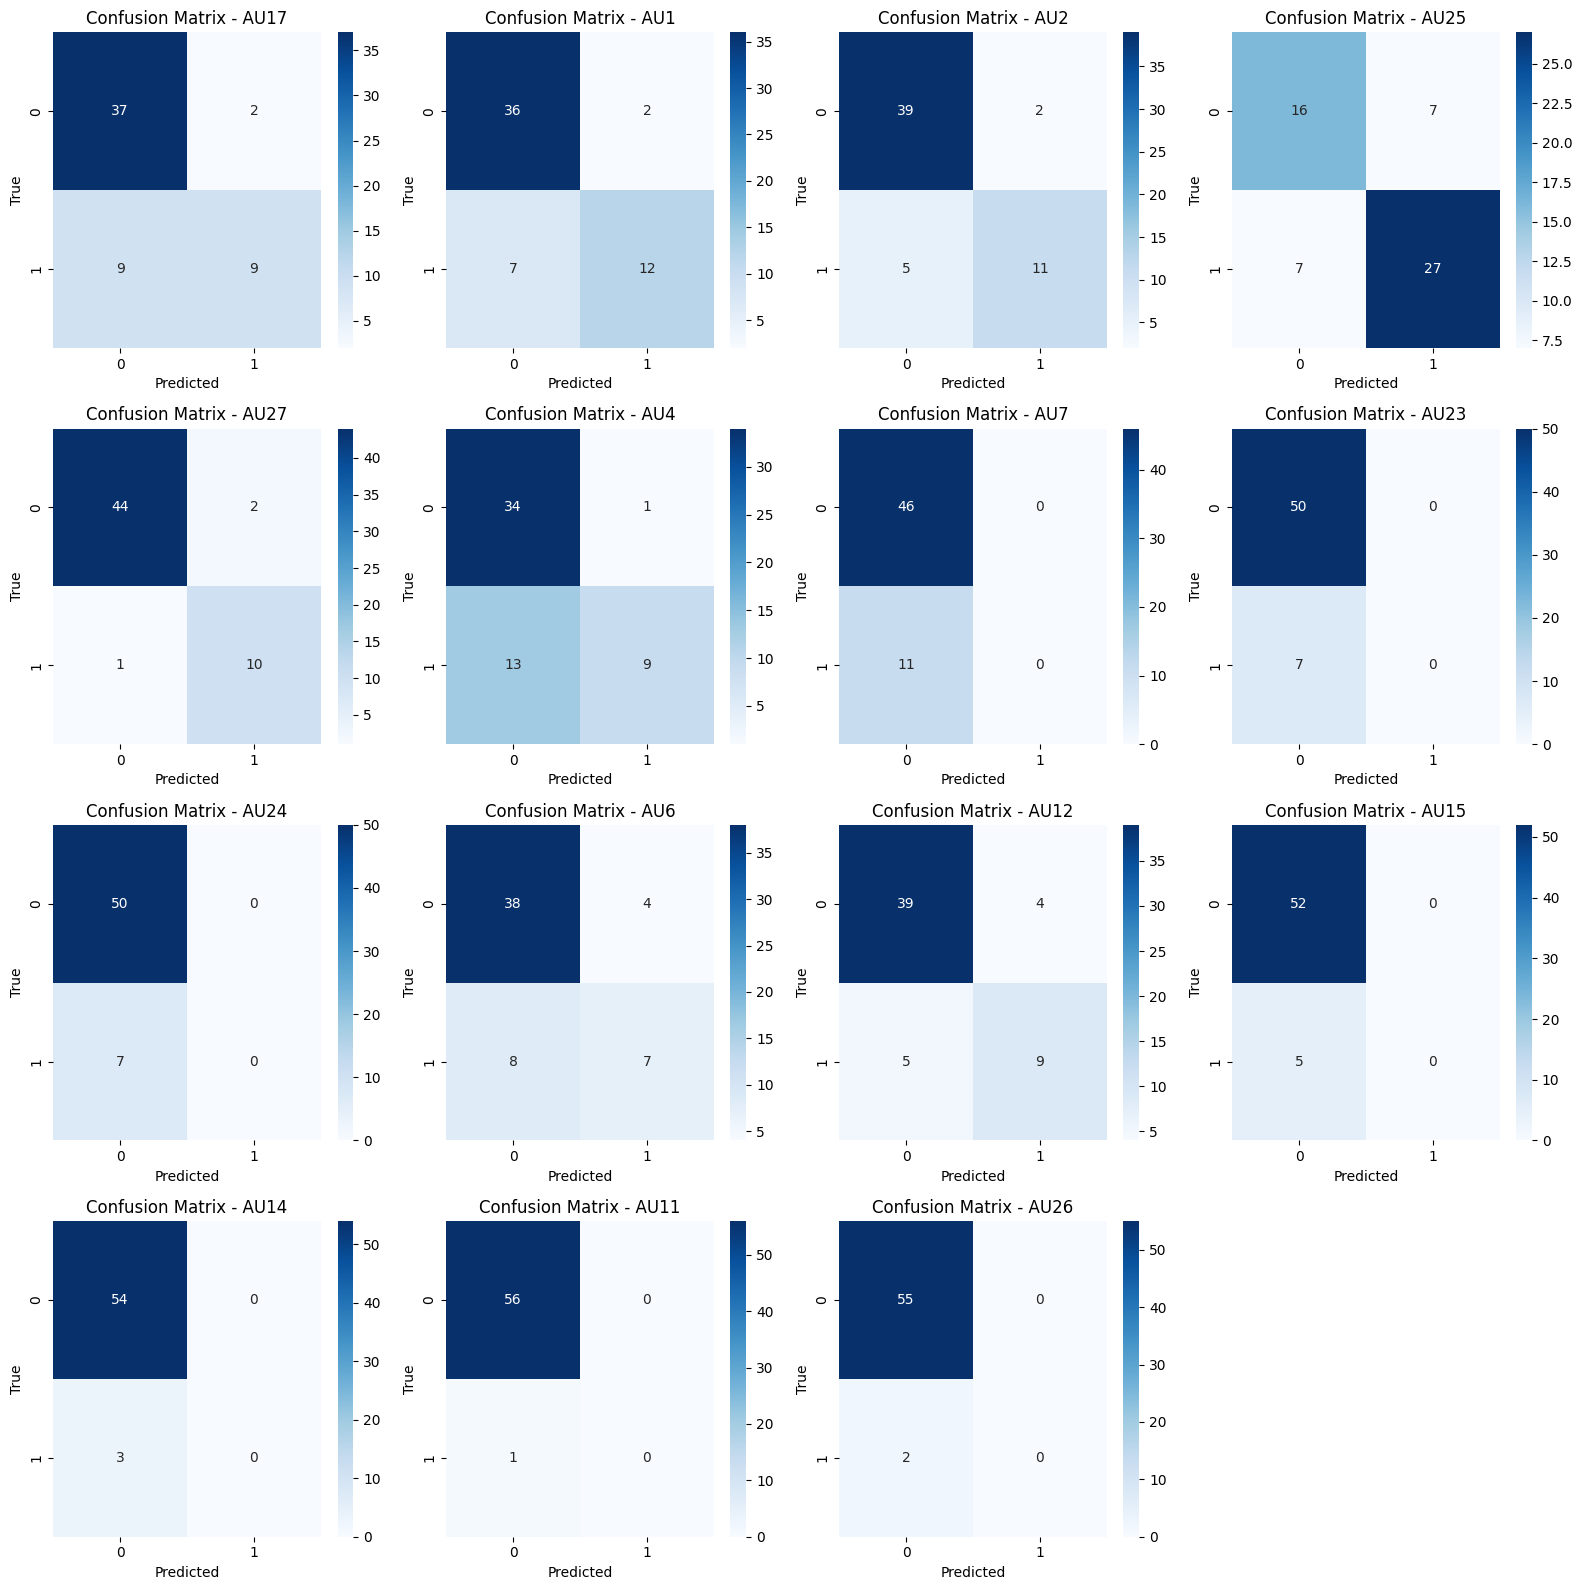

In [31]:
# Confusion Matrix for FACS Codes
true_labels_facs = test_facs_features
predicted_labels_facs = facs_predictions

num_facs_codes = true_labels_facs.shape[1]

# Calculate the number of rows needed based on 4 columns
num_rows = int(np.ceil(num_facs_codes / 4))

# Create subplots for each FACS code
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, 4*num_rows))

# Flatten the 2D array of subplots into a 1D array for easy indexing
axes = axes.flatten()

class_labels_facs = ['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26']

for i in range(num_facs_codes):
    facs_conf_matrix = confusion_matrix(true_labels_facs[:, i], predicted_labels_facs[:, i])
    sns.heatmap(facs_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {class_labels_facs[i]}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

# Remove any empty subplots
for j in range(num_facs_codes, num_rows*4):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# **Conclusion**

In this project, we developed a comprehensive model for facial expression analysis using a combination of FACS codes and high-level emotion labels. Leveraging a DenseNet201 pre-trained on ImageNet, the model demonstrated robust performance on a diverse dataset, capturing nuanced facial expressions and emotions.

## **Highlights**

  - Data Preprocessing: Robust data preprocessing and augmentation techniques were applied to enhance the model's resilience to diverse facial orientations, lighting conditions, and expressions. This contributed to the model's capacity to learn invariant features.

  - Model Architecture: The DenseNet201 architecture, with added dense layers and dropout regularization, proved effective in extracting complex hierarchical features from facial images.

  - Class Weights: Custom class weights were applied, addressing imbalances in the dataset and fostering equitable learning for both emotion and FACS code predictions.

  - Evaluation Metrics: Comprehensive evaluation metrics, including classification reports, confusion matrices, and visualizations, provided a thorough understanding of the model's performance on both emotion labels and individual FACS codes.

## **Future Improvements**

  - Fine-Tuning: While the pre-trained DenseNet201 was beneficial, future work could explore fine-tuning specific layers to adapt the model more closely to the nuances of facial expression data.

  - Data Diversity: Expanding the dataset to include a more diverse range of subjects, facial expressions, and environmental conditions could further enhance the model's generalization capabilities.

  Interpretable Models: Incorporating techniques for model interpretability, such as Grad-CAM, could provide insights into the specific facial regions influencing predictions.


